In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from collections import namedtuple
import numpy as np
import cupy as cp
import math

%run kernel.ipynb

4.84 μs ± 8.64 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
5.14 μs ± 68.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [2]:
config = Config()

In [3]:
%%time
IMAGES = []
IMAGE_FNAMES = {}

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.mode == 'L'
        image_index = len(IMAGES)
        IMAGES.append(np.array(image).ravel())
        IMAGE_FNAMES[image_index] = image_fname
        
    assert image.fp is None

assert len(IMAGES) == len(IMAGE_FNAMES)
IMAGES = np.array(IMAGES)
print(f'Loaded {len(IMAGES)} images')

  0%|          | 0/9146 [00:00<?, ?it/s]

Loaded 9145 images
CPU times: user 598 ms, sys: 131 ms, total: 730 ms
Wall time: 1.35 s


In [4]:
# Parameters of kernel generation. Subject to evolution
OUTLINE_WIDTH = 4/32
STRETCH_X_LEVELS = 7
STRETCH_Y_LEVELS = 7
ROTATION_LEVELS = 12
OFFSET_X_LEVELS = 5
OFFSET_Y_LEVELS = 5

assert STRETCH_X_LEVELS > 0 and STRETCH_X_LEVELS % 2
assert STRETCH_Y_LEVELS > 0 and STRETCH_Y_LEVELS % 2
assert OFFSET_X_LEVELS > 0 and OFFSET_X_LEVELS % 2
assert OFFSET_Y_LEVELS > 0 and OFFSET_Y_LEVELS % 2

In [5]:
stretch_x_transfs = []
stretch_y_transfs = []
rotation_transfs = []
offset_x_transfs = []
offset_y_transfs = []

# cover possible STRETCHES from 2x to 0.25x including 1
for i in range(STRETCH_X_LEVELS // 2):
    u = (1.0 + (i + 1) * (2 - 1) / (STRETCH_X_LEVELS // 2))
    d = (1.0 - (i + 1) * (1 - 0.25) / (STRETCH_X_LEVELS // 2))
    transf = [
        [u, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    stretch_x_transfs.append(np.array(transf))
    transf = [
        [d, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    stretch_x_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
stretch_x_transfs.append(np.array(transf))

# cover possible STRETCHES from 2x to 0.25x including 1
for i in range(STRETCH_Y_LEVELS // 2):
    u = (1.0 + (i + 1) * (2 - 1) / (STRETCH_Y_LEVELS // 2))
    d = (1.0 - (i + 1) * (1 - 0.25) / (STRETCH_Y_LEVELS // 2))
    transf = [
        [1, 0, 0],
        [0, u, 0],
        [0, 0, 1]
    ]
    stretch_y_transfs.append(np.array(transf))
    transf = [
        [1, 0, 0],
        [0, d, 0],
        [0, 0, 1]
    ]
    stretch_y_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
stretch_y_transfs.append(np.array(transf))

# cover possible rotations counter clock wise (0 - is no rotation)
for i in range(ROTATION_LEVELS):
    theta = (2 * math.pi / ROTATION_LEVELS) * i
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotation_transfs.append(np.array(transf))

# cover possible offsets from edge of an object to nearest edge of bounds
for i in range(OFFSET_X_LEVELS // 2):
    l = 1 / ((OFFSET_X_LEVELS - 1) // 2) * (i + 1)
    r = -l
    transf = [
        [1, 0, l],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))
    transf = [
        [1, 0, r],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
offset_x_transfs.append(np.array(transf))

# cover possible offsets from edge of an object to nearest edge of bounds
for i in range(OFFSET_Y_LEVELS // 2):
    u = 1 / ((OFFSET_Y_LEVELS - 1) // 2) * (i + 1)
    d = -u
    transf = [
        [1, 0, 0],
        [0, 1, u],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))
    transf = [
        [1, 0, 0],
        [0, 1, d],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
offset_y_transfs.append(np.array(transf))

In [6]:
TRANSFS = []

for a in stretch_x_transfs:
    for b in stretch_y_transfs:
        for c in rotation_transfs:
            for d in offset_x_transfs:
                for e in offset_y_transfs:
                    transf = a @ b @ c @ d @ e
                    TRANSFS.append(transf)

In [7]:
len(TRANSFS)

14700

In [8]:
def draw_kernel(p1, p2, p3, p4, size=32):
    image = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(image)
    draw.polygon([tuple(p1), tuple(p2), tuple(p3), tuple(p4)], fill=255, outline=255, width=1)
    return image

In [313]:
def display_kernel_raw(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        kernel = kernel.reshape(size, size).astype(np.uint8)
    else:
        assert kernel.shape[0] == kernel.shape[1]
    
    for r in kernel:
        s = ''
        for c in r:
            s += ' ' + str(c)

        print(s)            

In [350]:
%%time
KERNELS = []
KERNEL_PARAMS = []
KERNELS_AS_OBJ = []
half_kernel_size = (config.kernel_size - 1) / 2

# prototype is a simple vertical bar
z = OUTLINE_WIDTH / 2
points_gold = [
    [0   - z,  0   - z,   0   + z,  0   + z ],
    [0.5 + z, -0.5 - z,  -0.5 - z,  0.5 + z ],
    [1,        1,         1,        1  ]
]

for transf in TRANSFS:
    points = (transf @ points_gold).T
    points_x = (points[:,0] * half_kernel_size + half_kernel_size).astype(np.int32)
    points_y = (points[:,1] * -half_kernel_size + half_kernel_size).astype(np.int32)
    kernel_image = draw_kernel(
        (points_x[0], points_y[0]),
        (points_x[1], points_y[1]),
        (points_x[2], points_y[2]),
        (points_x[3], points_y[3]),
        size=config.kernel_size)
    kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
    kernel_unique_counts = np.unique_counts(np.append(kernel, [0, 1]))
    assert np.array_equal(kernel_unique_counts.values, [0, 1])
    ones_count = kernel_unique_counts.counts[1] - 1 # subtract 1 because it was added intentionally before (alongside with zero) 

    if ones_count <= 0: # Empty image was generated, ignore
        continue
    
    denominator = 255 * ones_count
    kernel = kernel.astype(np.float32)
    KERNELS.append(kernel)
    KERNEL_PARAMS.append([ones_count, denominator])

    kernel_as_obj = Kernel.from_m_data_nog((np.array(kernel_image) / 255).astype(np.uint8))
    assert kernel_as_obj.m_ones[0] == ones_count, (kernel_as_obj.m_ones[0], ones_count)
    KERNELS_AS_OBJ.append(kernel_as_obj)

KERNELS = np.array(KERNELS)
KERNEL_PARAMS = np.array(KERNEL_PARAMS)
KERNELS_AS_OBJ = np.array(KERNELS_AS_OBJ)
assert len(KERNELS) == len(KERNEL_PARAMS)
assert len(KERNELS) == len(KERNELS_AS_OBJ)

print(f'{len(KERNELS)} kernels generated')

12530 kernels generated
CPU times: user 7.97 s, sys: 8.67 ms, total: 7.98 s
Wall time: 7.98 s


In [351]:
%%time
# Deduplication
kernels_cross = KERNELS @ KERNELS.T
kernels_cross_norm = kernels_cross / KERNEL_PARAMS[:,0]
kernels_cross_norm_sum = kernels_cross_norm + kernels_cross_norm.T # 100% dups will give 1+1=2, 99% dups will give 0.99+0.99=1.98

CPU times: user 7.35 s, sys: 4.38 s, total: 11.7 s
Wall time: 1.86 s


In [352]:
# Verify cross score calculation
for _ in range(100):
    i = np.random.randint(kernels_cross.shape[0])
    j = np.random.randint(kernels_cross.shape[1])
    ones_j = KERNEL_PARAMS[j,0]
    #print(f'{i}\t{j}\t{kernels_cross[i,j]}\t{kernels_cross_norm[i,j]:.2f}\t{ones_j}')
    cross_norm = kernels_cross[i,j] / ones_j if ones_j > 0 else 0
    assert np.isclose(cross_norm, kernels_cross_norm[i,j]), (cross_norm, kernels_cross_norm[i,j])

In [353]:
%%time
KERNEL_DUPS_THRESHOLD=0.99
kernel_dups = []
kernels_for_remove = set()

for i, i_row in enumerate(kernels_cross_norm_sum):
    for j, s in enumerate(i_row):
        if j >= i: # either diagonal or upper right part of matrix encountered
            break

        if s >= (KERNEL_DUPS_THRESHOLD + KERNEL_DUPS_THRESHOLD): # treat 99% two-side intersection as redundant
            kernel_dups.append((i, j))
            kernels_for_remove.add(j)

total_kernel_for_remove = len(kernels_for_remove)
total_kernels = len(KERNELS)
print(f'Found {total_kernel_for_remove} of {total_kernels} ({(total_kernel_for_remove / total_kernels) * 100:.2f}%) duplicate kernels for {KERNEL_DUPS_THRESHOLD} threshold') 

Found 6923 of 12530 (55.25%) duplicate kernels for 0.99 threshold
CPU times: user 7.65 s, sys: 2.44 ms, total: 7.65 s
Wall time: 7.65 s


In [354]:
# Verify dups calculation against POJO Kernels
kernel_dups_indicies = np.random.randint(len(kernel_dups), size=100)

for i in kernel_dups_indicies:
    dup_entry = kernel_dups[i]
    kernel1 = KERNELS_AS_OBJ[dup_entry[0]]
    kernel2 = KERNELS_AS_OBJ[dup_entry[1]]
    is_match, match_score = kernel1.match(kernel2.m * 255, 0.01)
    assert match_score >= KERNEL_DUPS_THRESHOLD, (dup_entry, match_score)
    is_match, match_score = kernel2.match(kernel1.m * 255, 0.01)
    assert match_score >= KERNEL_DUPS_THRESHOLD, (dup_entry, match_score)

In [355]:
KERNELS = np.delete(KERNELS, list(kernels_for_remove), axis=0)
KERNEL_PARAMS= np.delete(KERNEL_PARAMS, list(kernels_for_remove), axis=0)
KERNELS_AS_OBJ= np.delete(KERNELS_AS_OBJ, list(kernels_for_remove), axis=0)


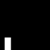
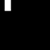
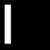
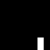
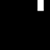
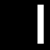
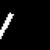
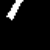
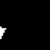
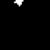
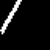
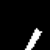
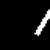
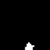
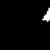
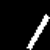
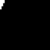
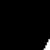
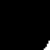
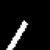
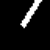
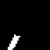
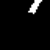
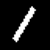
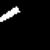
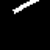
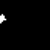
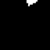
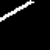
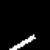
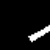
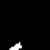
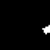
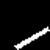
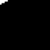
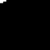
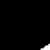
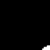
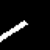
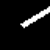
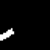
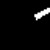
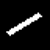
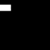
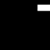
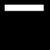
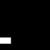
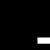
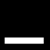
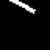
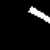
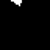
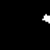
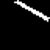
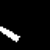
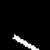
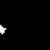
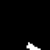
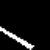
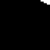
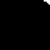
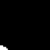
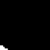
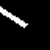
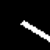
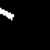
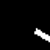
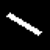
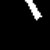
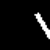
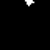
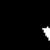
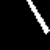
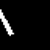
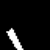
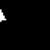
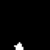
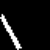
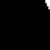
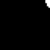
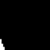
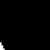
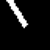
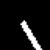
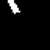
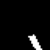
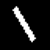
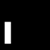
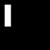
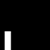
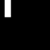
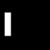
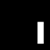
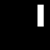
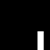
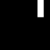
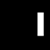
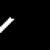
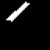
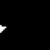
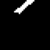
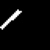
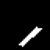
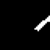
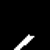
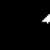
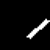
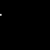
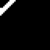
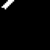
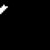
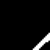
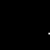
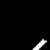
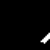
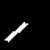
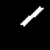
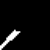
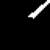
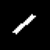
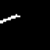
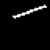
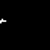
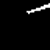
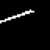
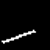
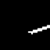
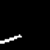
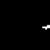
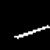
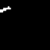
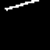
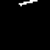
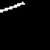
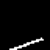
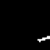
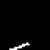
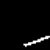
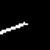
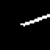
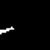
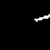
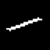
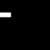
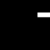
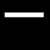
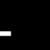
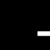
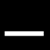
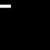
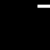
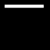
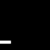
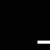
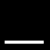
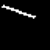
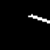
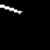
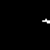
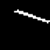
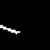
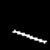
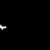
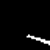
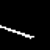
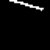
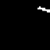
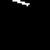
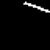
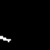
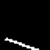
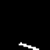
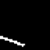
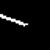
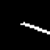
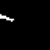
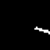
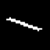
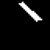
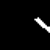
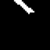
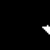
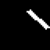
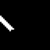
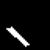
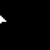
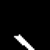
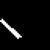
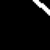
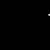
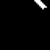
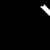
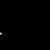
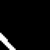
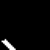
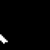
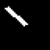
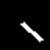
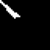
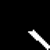
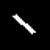
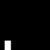
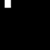
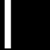
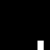
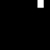
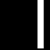
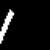
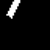
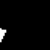
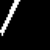
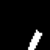
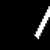
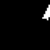
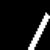
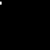
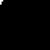
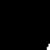
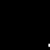
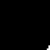
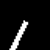
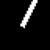
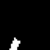
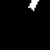
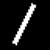
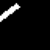
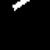
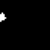
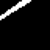
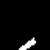
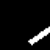
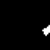
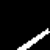
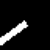
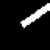
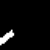
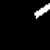
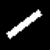
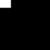
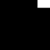
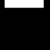
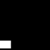
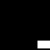
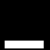
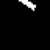
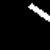
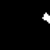
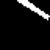
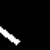
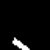
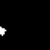
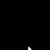
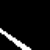
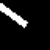
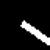
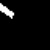

In [356]:
max_to_show = 256

if max_to_show > 0:
    kernel_images = np.copy(KERNELS[:max_to_show])
    kernel_image_denoms = KERNEL_PARAMS[:max_to_show,1]
else:
    kernel_images = np.copy(KERNELS)
    kernel_image_denoms = KERNEL_PARAMS[:,1]

# Turn to column vector
assert kernel_image_denoms.shape == (max_to_show,)
kernel_image_denoms = kernel_image_denoms.reshape(1,-1).T
assert kernel_image_denoms.shape == (max_to_show, 1)
#kernel_images *= kernel_image_denoms # turn to 0..1
kernel_images *= 255 # turn to 0..255

_images = []

for i in range(kernel_images.shape[0]):
    assert config.kernel_size * config.kernel_size == kernel_images[i].shape[0]
    _image = Image.frombytes('L', size=(config.kernel_size, config.kernel_size), data=kernel_images[i].astype(np.uint8))
    _image = _image.resize((50, 50))
    _images.append(_image)
    
display_images_grid(_images, 16)

In [357]:
%%time

kernel_denoms = KERNEL_PARAMS[:,1]
kernel_denoms = kernel_denoms.reshape(1,-1).T
KERNELS_SCALED = KERNELS / kernel_denoms 
MATCH_MATRIX = IMAGES @ KERNELS_SCALED.T

CPU times: user 7.23 s, sys: 2 s, total: 9.23 s
Wall time: 853 ms


In [358]:
# verify correctness vs Kernel POJO
image_random_indices = np.random.randint(len(IMAGES), size=(100,))
kernel_random_indices = np.random.randint(len(KERNELS), size=(100,))

for i in image_random_indices:
    for j in kernel_random_indices:
        match_score1 = MATCH_MATRIX[i,j]
        image = IMAGES[i].reshape(config.kernel_size, config.kernel_size)
        kernel = KERNELS_AS_OBJ[j]
        assert np.array_equal(kernel.m, KERNELS[j].reshape(config.kernel_size, config.kernel_size))
        match_score2 = kernel.match(image, 0.01)[1]
        assert np.isclose(match_score1, match_score2), (i, j, match_score1, match_score2)

In [360]:
success_matches = MATCH_MATRIX > config.kernel_match_threshold # which kernels were turned on
success_matches = success_matches @ np.full((MATCH_MATRIX.shape[1],), 1 / MATCH_MATRIX.shape[1]) # percentage of kernels which were turned on for each image
success_matches_count = (success_matches > config.kernel_grid_match_threshold) @ np.full((MATCH_MATRIX.shape[0],), 1)
success_matches_count / len(IMAGES)

np.float64(0.43171131765992343)

In [361]:
thres_to_percentage = []
z = np.full((MATCH_MATRIX.shape[0],), 1)
interesting_points = [
    [0.99, None], 
    [0.95, None],
    [0.9, None],
    [0.8, None],
    [0.5, None]
]

for thres in range(100):
    point = thres / 100
    x = (success_matches > point) @ z
    x = x / len(IMAGES)
    thres_to_percentage.append([point, x])

    for ip in interesting_points:
        if x < ip[0] and ip[1] is None:
            ip[1] = point
            break

thres_to_percentage = np.array(thres_to_percentage)

In [362]:
interesting_points

[[0.99, 0.01], [0.95, 0.03], [0.9, 0.04], [0.8, 0.06], [0.5, 0.1]]

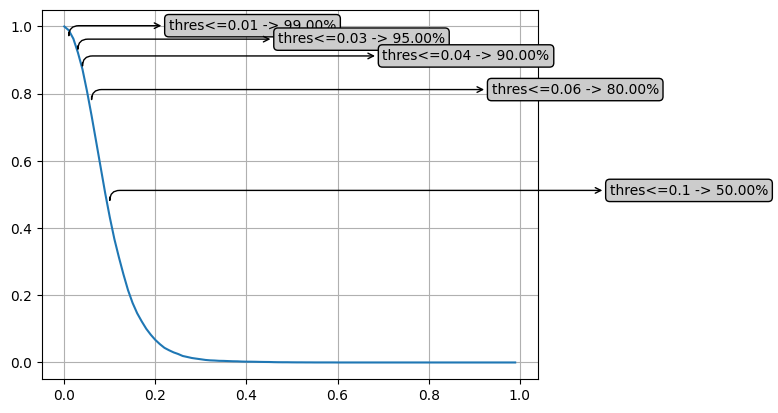

In [389]:
fig, ax = plt.subplots()
offset = -72
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="<-",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

ax.plot(thres_to_percentage[:,0], thres_to_percentage[:,1])

for i, ip in enumerate(interesting_points):
    ax.annotate(
        f'thres<={ip[1]} -> {ip[0]*100:.2f}%',
        (ip[1], ip[0]),
        xytext=(-(i+1)*offset,0), textcoords='offset points',
        bbox=bbox, arrowprops=arrowprops)
ax.grid()
plt.show()